In [76]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Fraud.csv')

Data cleaning including missing values, outliers and multi-collinearity

step                0.375177
amount             30.993949
oldbalanceOrg       5.249136
newbalanceOrig      5.176884
oldbalanceDest     19.921758
newbalanceDest     19.352302
isFraud            27.779538
isFlaggedFraud    630.603629
type_CASH_OUT       0.621319
type_DEBIT         12.270876
type_PAYMENT        0.684258
type_TRANSFER       3.005134
dtype: float64


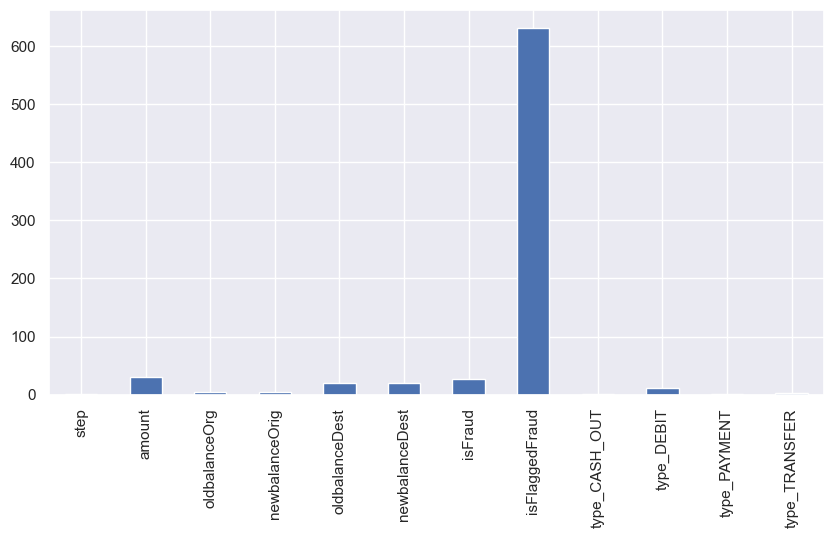

In [78]:
# Create dummy variables for categorical columns
df = pd.get_dummies(df, columns=['type'], drop_first=True)
# Check for skewness and visualize it
df_1 = df.drop(columns=['nameOrig', 'nameDest'])
df_1.skew().plot(kind='bar')
print(df_1.skew())

step              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
type_CASH_OUT     0
type_DEBIT        0
type_PAYMENT      0
type_TRANSFER     0
dtype: int64


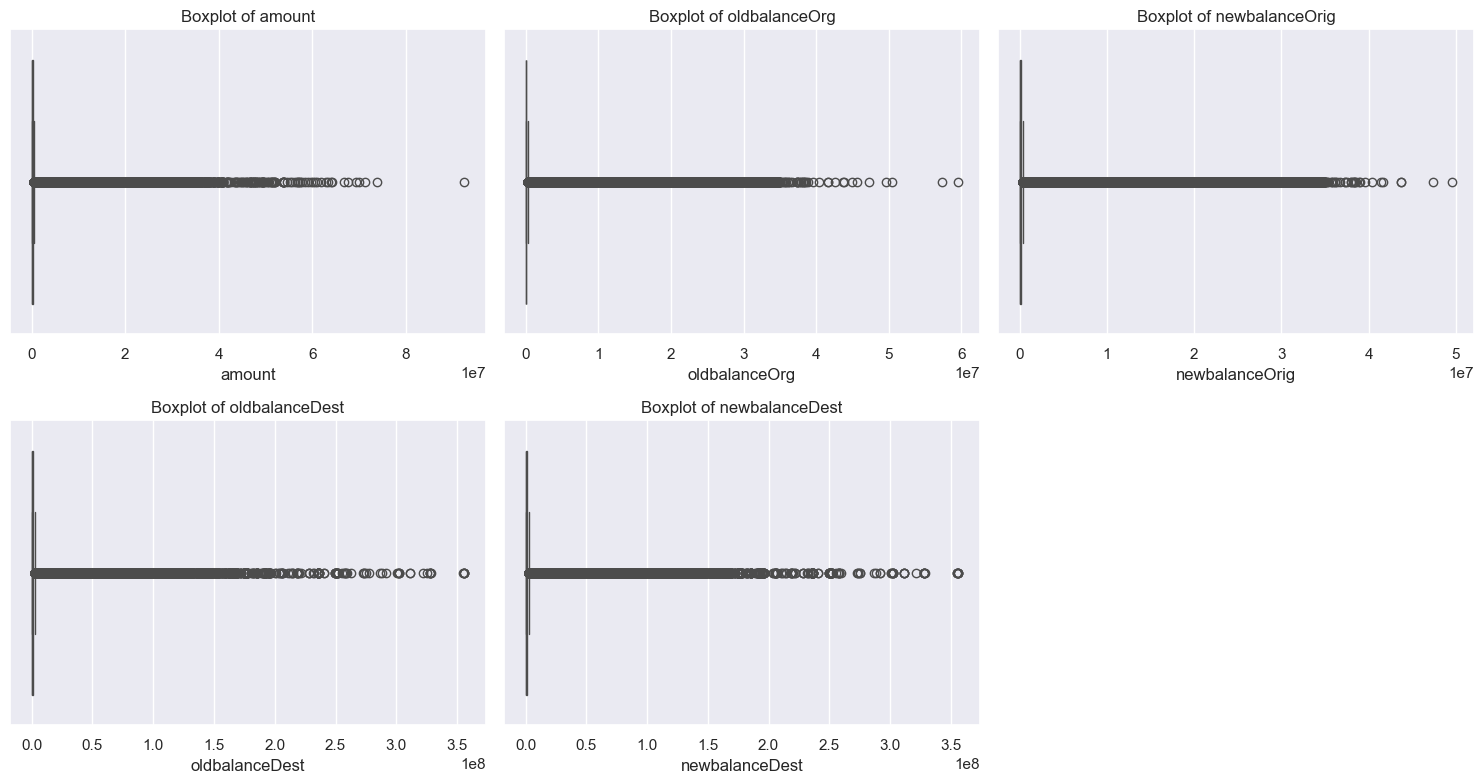

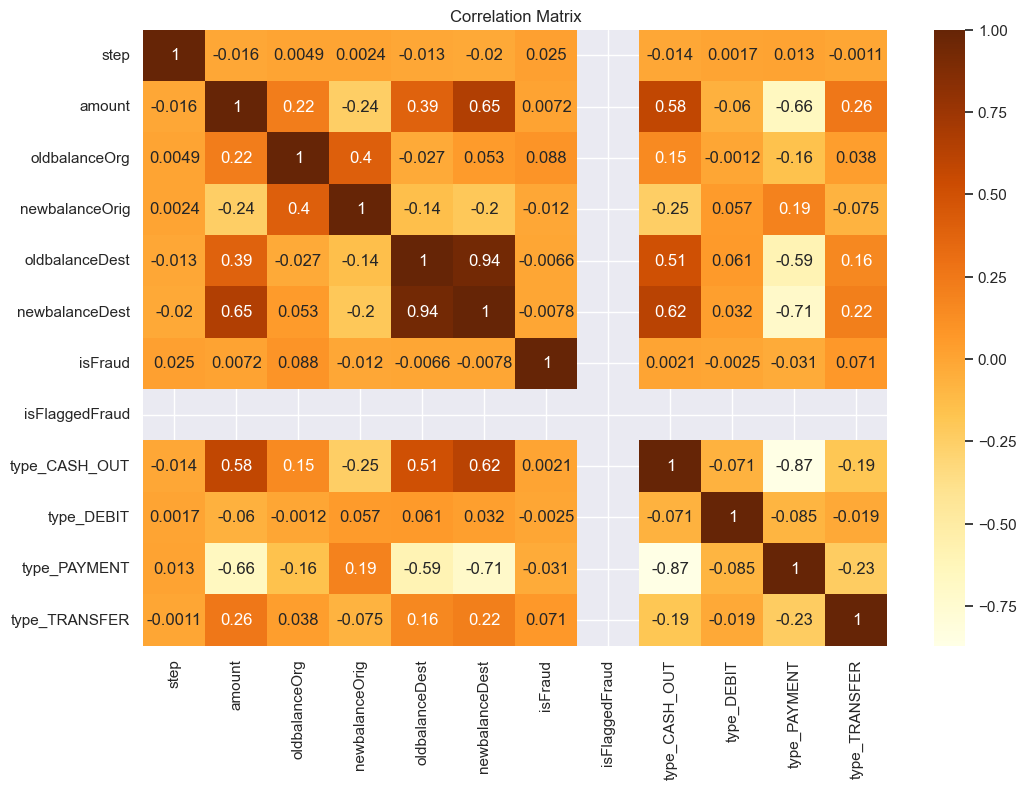

In [79]:
# Check for missing values
print(df.isnull().sum())

# Check for outliers using boxplots
plt.figure(figsize=(15, 8))
for i, column in enumerate(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
# Adjust layout
plt.tight_layout()
plt.show()

# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for column in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    df = remove_outliers(df, column)

# Remove non-numeric columns
df_2 = df.drop(columns=['nameOrig', 'nameDest'])


# Check for multi-collinearity using correlation matrix
corr_matrix = df_2.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlOrBr')
plt.title('Correlation Matrix')
plt.show()

Model Building, Evaluation and Prediction

[[974511     14]
 [   348    550]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    974525
           1       0.98      0.61      0.75       898

    accuracy                           1.00    975423
   macro avg       0.99      0.81      0.88    975423
weighted avg       1.00      1.00      1.00    975423

ROC AUC Score: 0.9906792378835237


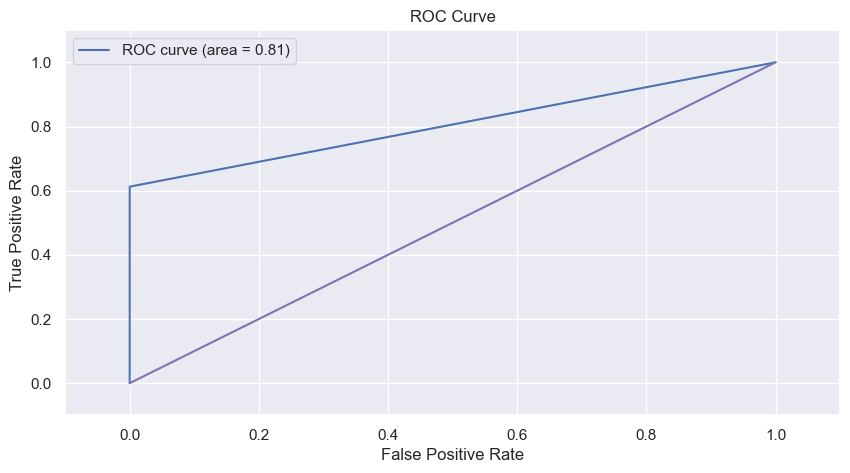

In [80]:
# Import necessary libraries for model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

# Prepare the data
X = df.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)
y = df['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_prob)}')

# ROC curve and AUC
sns.set(rc={'figure.figsize':(10,5)})
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'm-')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# It takes 13 minutes to run

Feature Importance

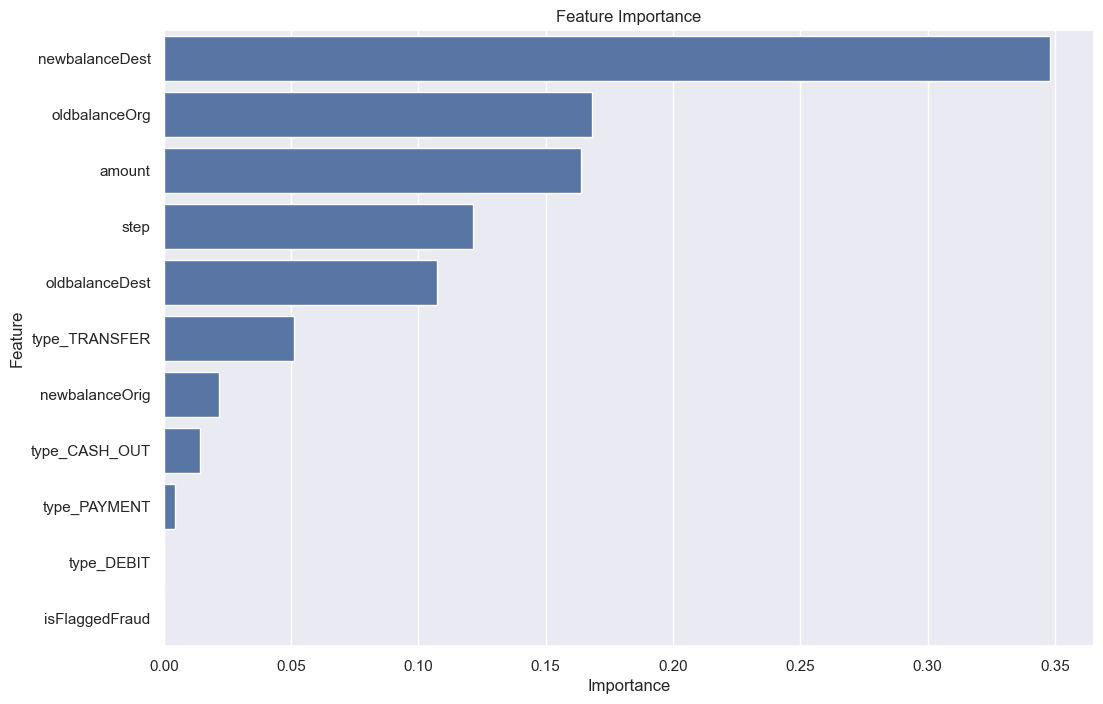

In [81]:
importances = model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


Final Analysis

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    974525
           1       0.98      0.61      0.75       898

    accuracy                           1.00    975423
   macro avg       0.99      0.81      0.88    975423
weighted avg       1.00      1.00      1.00    975423

ROC AUC Score: 0.9906792378835237


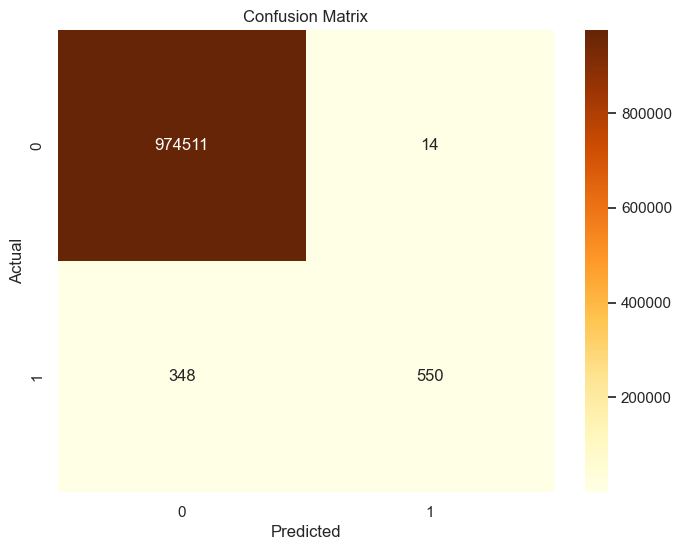

In [82]:
# Performance Metrics
print(classification_report(y_test, y_pred))
print(f'ROC AUC Score: {roc_auc_score(y_test, y_prob)}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [83]:
# Key Factors Analysis
top_features = feature_importance_df.head(10)
print(top_features)

           Feature  Importance
5   newbalanceDest    0.347959
2    oldbalanceOrg    0.168108
1           amount    0.163820
0             step    0.121429
4   oldbalanceDest    0.107264
10   type_TRANSFER    0.050933
3   newbalanceOrig    0.021789
7    type_CASH_OUT    0.014010
9     type_PAYMENT    0.004493
8       type_DEBIT    0.000194
